In [1]:
from pathlib import Path
import skimage.io as io
import SimpleITK as sitk
import matplotlib.pylab as plt
import numpy as np
import cv2 
# from skimage.transform import resize
import math 
from sklearn.utils import shuffle
from sys import stdout
import sys
import gc

In [2]:
# pip install SimpleITK
# pip install opencv-python

In [3]:
# img = io.imread(data_dir/'Case00.mhd', plugin='simpleitk')

In [4]:
# images = sitk.GetArrayFromImage(sitk.ReadImage(data_dir/'Case00.mhd', sitk.sitkFloat32))  # Case00.mhd, Case00_segmentation.mhd

# plt.figure(figsize=(25,20))
# plt.gray()
# plt.subplots_adjust(0,0,1,1,0.01,0.01)
# print(images.shape[0])
# for i in range(images.shape[0]):
#     plt.subplot(9,6,i+1), plt.imshow(images[i]), plt.axis('off')
#     # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
# plt.show()


# plt.imshow(images[20])

In [5]:
# function for loading and preparing the data
def prepare_data(data_dir, num_case, start_num_case):
    """function for loading and preparing the data
    in: path to the directory for the data, number of cases in the directory
    out: Data (x, y)"""
    

    for i in range(start_num_case, start_num_case+num_case):
        image_name = 'Case' + "%02d" % i + '.mhd'
        segmentation_name = 'Case' + "%02d" % i + '_segmentation.mhd'

        # load images (x) for case i
        images = sitk.GetArrayFromImage(sitk.ReadImage(data_dir/image_name, sitk.sitkFloat32))
        # load segementations (y) for case i
        segmentations = sitk.GetArrayFromImage(sitk.ReadImage(data_dir/segmentation_name, sitk.sitkFloat32))

        # resize images to make all similar w.r.t width and length
        new_width, new_height = 350, 350  # 256, 256
        new_width_segmentations, new_height_segmentations = 260, 260
        resized_images = np.zeros((images.shape[0], 1, new_width, new_height))
        resized_segmentations = np.zeros((images.shape[0], 1, new_width_segmentations, new_height_segmentations))
        for j in range(images.shape[0]):
            resized_images[j, 0,:, :] = cv2.resize(images[j], (new_width, new_height), 
                               interpolation=cv2.INTER_NEAREST)
            resized_segmentations[j, 0,:, :] = cv2.resize(segmentations[j], (new_width_segmentations, new_height_segmentations), 
                               interpolation=cv2.INTER_NEAREST)


        if i==start_num_case:
            x = resized_images
            y= resized_segmentations
        else:
            x = np.concatenate((x, resized_images), axis=0)
            y = np.concatenate((y, resized_segmentations), axis=0)

#         print(x.shape, y.shape)

    return x, y


In [6]:
# Load data
# part 1: train
data_dir = Path('C:/Amin/Workspace/Data/Prostate/TrainingData_Part1') # for part 1: num_case=26, start_num_case = 0
x_train, y_train = prepare_data(data_dir=data_dir, num_case=26, start_num_case=0)
print(x_train.shape, y_train.shape)

# part 2: Validation
data_dir = Path('C:/Amin/Workspace/Data/Prostate/TrainingData_Part2') # for part 3: num_case=12, start_num_case = 26
x_val, y_val = prepare_data(data_dir=data_dir, num_case=12, start_num_case=26)
print(x_val.shape, y_val.shape)

# part 3: test
data_dir = Path('C:/Amin/Workspace/Data/Prostate/TrainingData_Part3') # for part 3: num_case=12, start_num_case = 38
x_test, y_test = prepare_data(data_dir=data_dir, num_case=12, start_num_case=38)
print(x_test.shape, y_test.shape)

(800, 1, 350, 350) (800, 1, 260, 260)
(289, 1, 350, 350) (289, 1, 260, 260)
(288, 1, 350, 350) (288, 1, 260, 260)


# U-net

In [7]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange
from time import sleep
use_gpu = torch.cuda.is_available() #  False

C:\Users\amina\anaconda3\envs\torch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
torch.cuda.empty_cache()

In [9]:
batch_size = 9
epochs = 51 # 1000
epoch_lapse = 50
threshold = 0.5
sample_size = None

In [10]:
width = 350
height = 350
width_out = 260
height_out = 260

In [11]:
class myUNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    # conv1
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.ReLU(),
                    
                    # conv2
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.ReLU(), 
            
                    # maxpool comes after, since result before maxpool is required
                )
        return block
    
    
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    # conv1
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ReLU(),
                    
                    # conv2
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ReLU(),
                    
                    # up-conv?
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                    )
            return  block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    # conv1
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ReLU(),
                
                    # conv2
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ReLU(),
                    
                    # conv3 is'nt it 1D?
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.ReLU(),
                    )
            return  block
        
    def __init__(self, in_channel, out_channel):
        super().__init__()
        # contracting
        # 1
        self.c_1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.m_1 = torch.nn.MaxPool2d(kernel_size=2)
        
        # 2
        self.c_2 = self.contracting_block(in_channels=64, out_channels=128)
        self.m_2 = torch.nn.MaxPool2d(kernel_size=2)
        
        # 3
        self.c_3 = self.contracting_block(in_channels=128, out_channels=256)
        self.m_3 = torch.nn.MaxPool2d(kernel_size=2)
        
        # Bottleneck
        self.b_1 = self.expansive_block(in_channels=256, mid_channel=512, out_channels=256)
    
        # expansive
        # 1
        self.e_1 = self.expansive_block(in_channels=512, mid_channel=256, out_channels=128)
        
        # 2
        self.e_2 = self.expansive_block(in_channels=256, mid_channel=128, out_channels=64)
        
        # 3
        self.f_1 = self.final_block(in_channels=128, mid_channel=64, out_channels=out_channel)
        
    def crop_and_concat_torch(self, upsampled, bypass):
        # bypass is larger than upsampled
        dim3_diff = bypass.size()[2] - upsampled.size()[2]
        dim4_diff = bypass.size()[3] - upsampled.size()[3]
        
        bypass = F.pad(bypass, (-math.floor(dim3_diff/2), -math.ceil(dim3_diff/2),
                                -math.floor(dim4_diff/2), -math.ceil(dim4_diff/2)))
        return torch.cat((upsampled, bypass), 1)
    
        
    def forward(self, x):
        # contracting
        # 1
        out_c1 = self.c_1(x)
        out_m1 = self.m_1(out_c1)
        
        # 2
        out_c2 = self.c_2(out_m1)
        out_m2 = self.m_2(out_c2)
        
        # 3
        out_c3 = self.c_3(out_m2)
        out_m3 = self.m_3(out_c3)
        
        # Bottleneck
        out_b1 = self.b_1(out_m3)
        
        # expansive
        # 1
        cancat_result = self.crop_and_concat_torch(out_b1, out_c3)  # out_b1 and out_c3
        out_e1 = self.e_1(cancat_result)
        
        # 2
        cancat_result = self.crop_and_concat_torch(out_e1, out_c2)  # out_e1 and out_c2
        out_e2 = self.e_2(cancat_result)
        
        # 3
        cancat_result = self.crop_and_concat_torch(out_e2, out_c1)  # out_e2 and out_c1
        out_f1 = self.f_1(cancat_result)
        
        return  out_f1
        
        

In [12]:
model = myUNet(in_channel=1, out_channel=2)
model.cuda()

myUNet(
  (c_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (m_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (m_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e

# Train model

In [13]:
train_data = x_train[:,:,:,:]
train_labels = y_train[:,:,:,:]

In [14]:
torch.cuda.empty_cache()

In [15]:
# define the optimization
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.99)

# enumerate epochs
for epoch in range(100): #10
    print("\nEpoch ", epoch, ": ")
    
    train_data_record_indices = range(0, train_data.shape[0])
    train_data_record_indices_shuffled = shuffle(train_data_record_indices)
    
    batch_size = 5
    num_batches = int(train_data.shape[0]/batch_size)
    chunk_indices = np.array_split(train_data_record_indices_shuffled, num_batches)
            
            
    # enumerate mini batches
    for i in range(num_batches):  # range(num_batches)  
#         print("batch: ", i, "out of ", num_batches)

#         # free space in GPU
#         free_space()

        a = int((i*10/num_batches))+1
        b = "=" * a
        stdout.write("\r"+ "["  + b + "] " + str(int((i+1)*100/num_batches)) + " %")     
        del b
        stdout.flush()
        
        inputs, targets = train_data[chunk_indices[i]], train_labels[chunk_indices[i]]
#         sys.exit()
#         inputs = np.reshape(inputs, (inputs.shape[0], 1, 350, 350))
        inputs = torch.Tensor(inputs).cuda()
        # targets = torch.Tensor(targets).cuda()
        targets = torch.Tensor(targets).long()
        targets = targets.cuda()
#         targets = targets.type(torch.LongTensor)
        # clear the gradients
        optimizer.zero_grad()
        

        
        # compute the model output
        yhat = model(inputs)
        
        ###
        yhat = yhat.permute(0, 2, 3, 1)
#         print("1>>>",yhat.shape,targets.shape)
        yhat = yhat.resize(batch_size*width_out*height_out, 2)
        targets = targets.resize(batch_size*width_out*height_out)
#         print("1>>>",yhat.shape,targets.shape)
        
        # calculate loss
        loss = criterion(yhat, targets)
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()


Epoch  0 : 
[=] 0 %

C:\Users\amina\anaconda3\envs\torch_env\lib\site-packages\torch\_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


[==========] 100 %
Epoch  1 : 
[==========] 100 %
Epoch  2 : 
[==========] 100 %
Epoch  3 : 
[==========] 100 %
Epoch  4 : 
[==========] 100 %
Epoch  5 : 
[==========] 100 %
Epoch  6 : 
[==========] 100 %
Epoch  7 : 
[==========] 100 %
Epoch  8 : 
[==========] 100 %
Epoch  9 : 
[==========] 100 %
Epoch  10 : 
[==========] 100 %
Epoch  11 : 
[==========] 100 %
Epoch  12 : 
[==========] 100 %
Epoch  13 : 
[==========] 100 %
Epoch  14 : 
[==========] 100 %
Epoch  15 : 
[==========] 100 %
Epoch  16 : 
[==========] 100 %
Epoch  17 : 
[==========] 100 %
Epoch  18 : 
[==========] 100 %
Epoch  19 : 
[==========] 100 %
Epoch  20 : 
[==========] 100 %
Epoch  21 : 
[==========] 100 %
Epoch  22 : 
[==========] 100 %
Epoch  23 : 
[==========] 100 %
Epoch  24 : 
[==========] 100 %
Epoch  25 : 
[==========] 100 %
Epoch  26 : 
[==========] 100 %
Epoch  27 : 
[==========] 100 %
Epoch  28 : 
[==========] 100 %
Epoch  29 : 
[==========] 100 %
Epoch  30 : 
[==========] 100 %
Epoch  31 : 
[==========] 100 

# Evaluate

In [16]:
# torch.cuda.empty_cache()

In [17]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [18]:
# import gc
# del variables
gc.collect()

0

In [19]:
def free_space():
    gc.collect()

In [20]:
test_data = x_test[:,:,:,:]
test_labels = y_test[:,:,:,:]
print(test_data.shape,test_labels.shape)

(288, 1, 350, 350) (288, 1, 260, 260)


In [21]:
def get_val_loss(x_val, y_val, m):
    m = x_val.shape[0]
    outputs = model(x_val)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(m*width_out*height_out, 2)
    labels = y_val.resize(m*width_out*height_out)
    loss = F.cross_entropy(outputs, labels)
    return loss.data

In [22]:
test_data_record_indices = range(0, test_data.shape[0])
test_data_record_indices_shuffled = shuffle(test_data_record_indices)

batch_size = 3
num_batches = int(test_data.shape[0]/batch_size)
chunk_indices = np.array_split(test_data_record_indices_shuffled, num_batches)

total_loss = 0
with torch.no_grad():
    # enumerate mini batches
    for i in range(num_batches):  # range(num_batches)  
    #         print("batch: ", i, "out of ", num_batches)
        # free space in GPU
        free_space()



        inputs, targets = test_data[chunk_indices[i]], test_labels[chunk_indices[i]]


    #     print(inputs.shape, targets.shape)
        m = inputs.shape[0]

        inputs = torch.Tensor(inputs).cuda()
        # targets = torch.Tensor(targets).cuda()
        targets = torch.Tensor(targets).long()
        targets = targets.cuda()


        # evaluate the model on the test set
    #     yhat = model(inputs)
    #     yhat = yhat.detach()
    #     loss = F.cross_entropy(yhat, targets)
        batch_loss = get_val_loss(inputs, targets, m)
        total_loss += batch_loss

        a = int((i*10/num_batches))+1
        b = "=" * a
        stdout.write("\r"+ "["  + b + "] " + str(int((i+1)*100/num_batches)) + " %" + 
                    ", loss: " + str(batch_loss) + ", total_loss: " + str(total_loss))     
        del b
        stdout.flush()
    #     print("loss: ", batch_loss, "total_loss: ", total_loss)
    

    


[==========] 100 %, loss: tensor(0.0420, device='cuda:0'), total_loss: tensor(3.4640, device='cuda:0')

# plot results

In [23]:
plt.rcdefaults() 

In [24]:
def plot_examples(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18,4*num_examples))
    m = datax.shape[0]
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = model(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][1].imshow(np.transpose(image_arr, (1,2,0))[:,:,0])
        ax[row_num][1].set_title("Segmented Image")
        ax[row_num][2].imshow(image_arr.argmax(0))
        ax[row_num][2].set_title("Segmented Image localization")
        ax[row_num][3].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
        ax[row_num][3].set_title("Target image")
    plt.show()

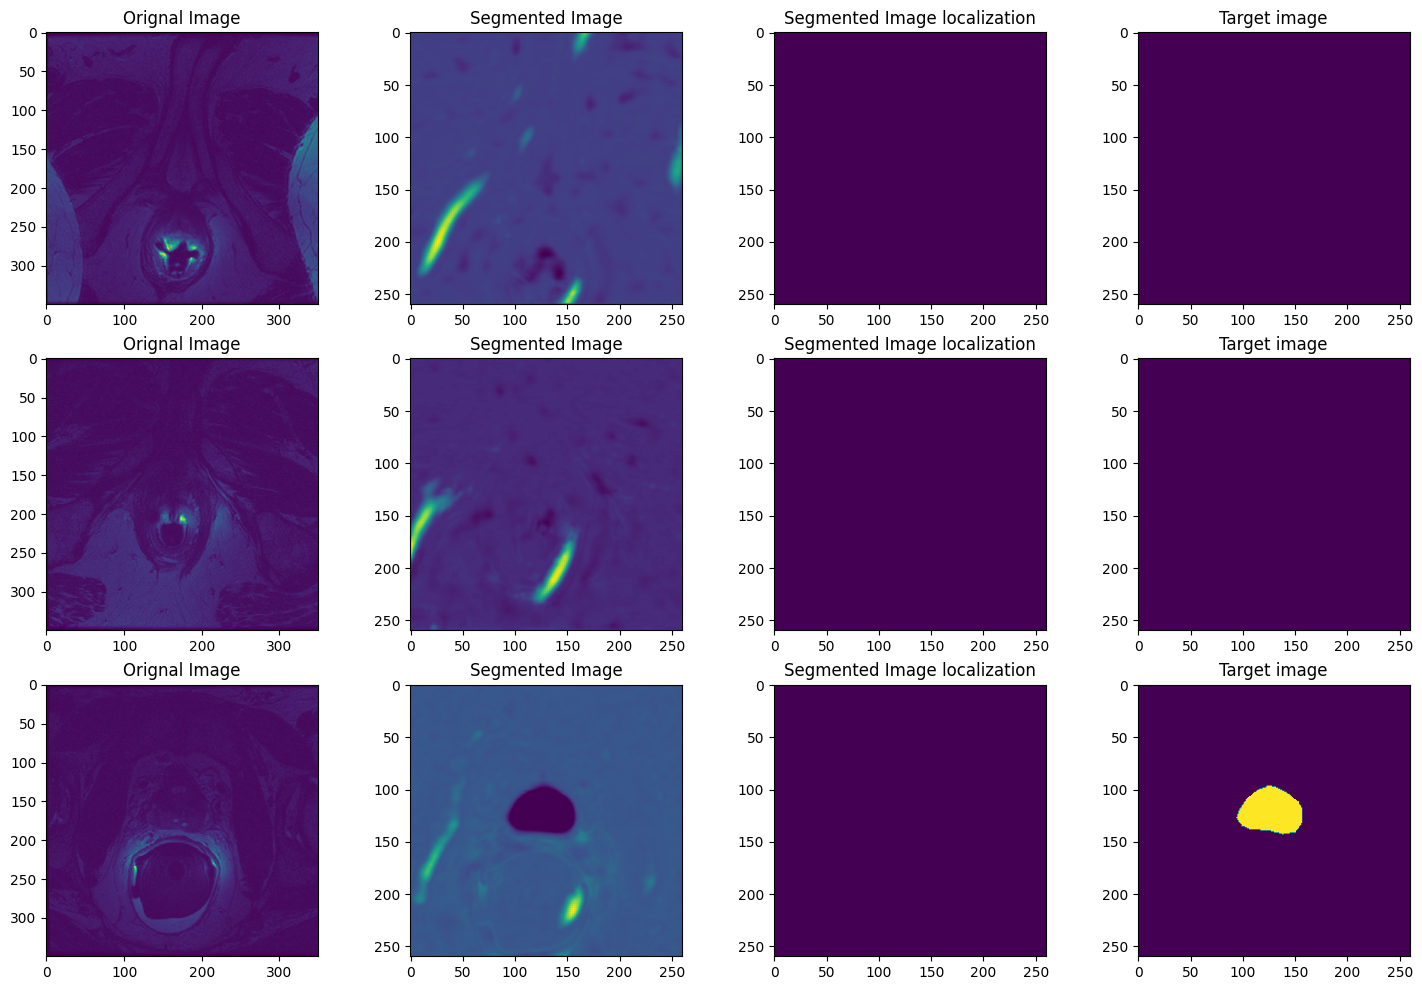

In [25]:
plot_examples(x_train, y_train)

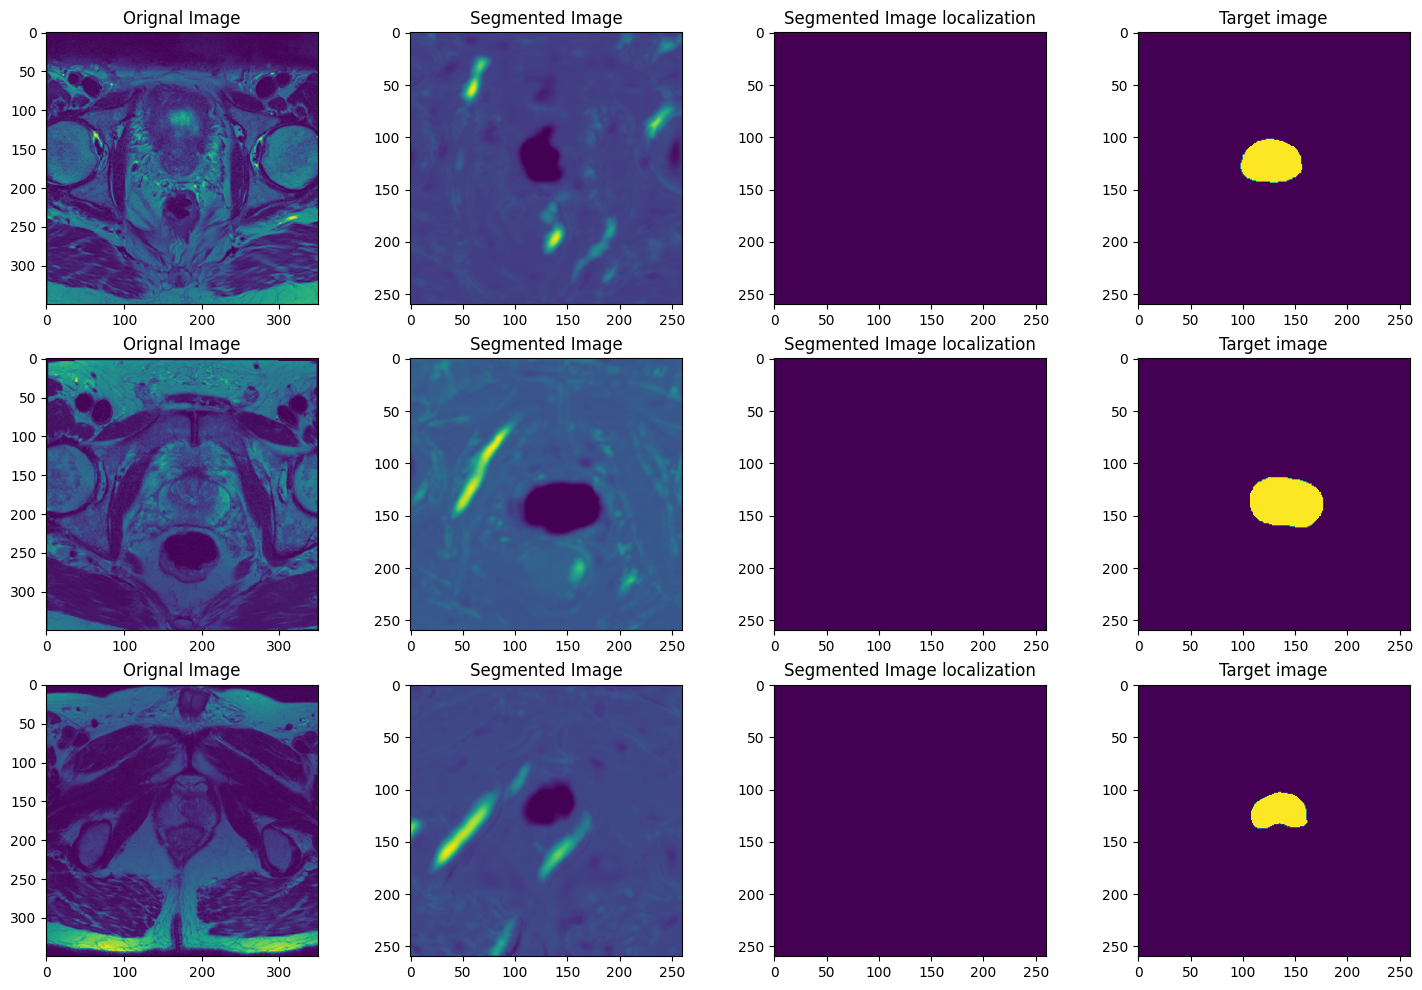

In [26]:
plot_examples(x_val, y_val)

((289, 1, 350, 350), (289, 1, 260, 260))


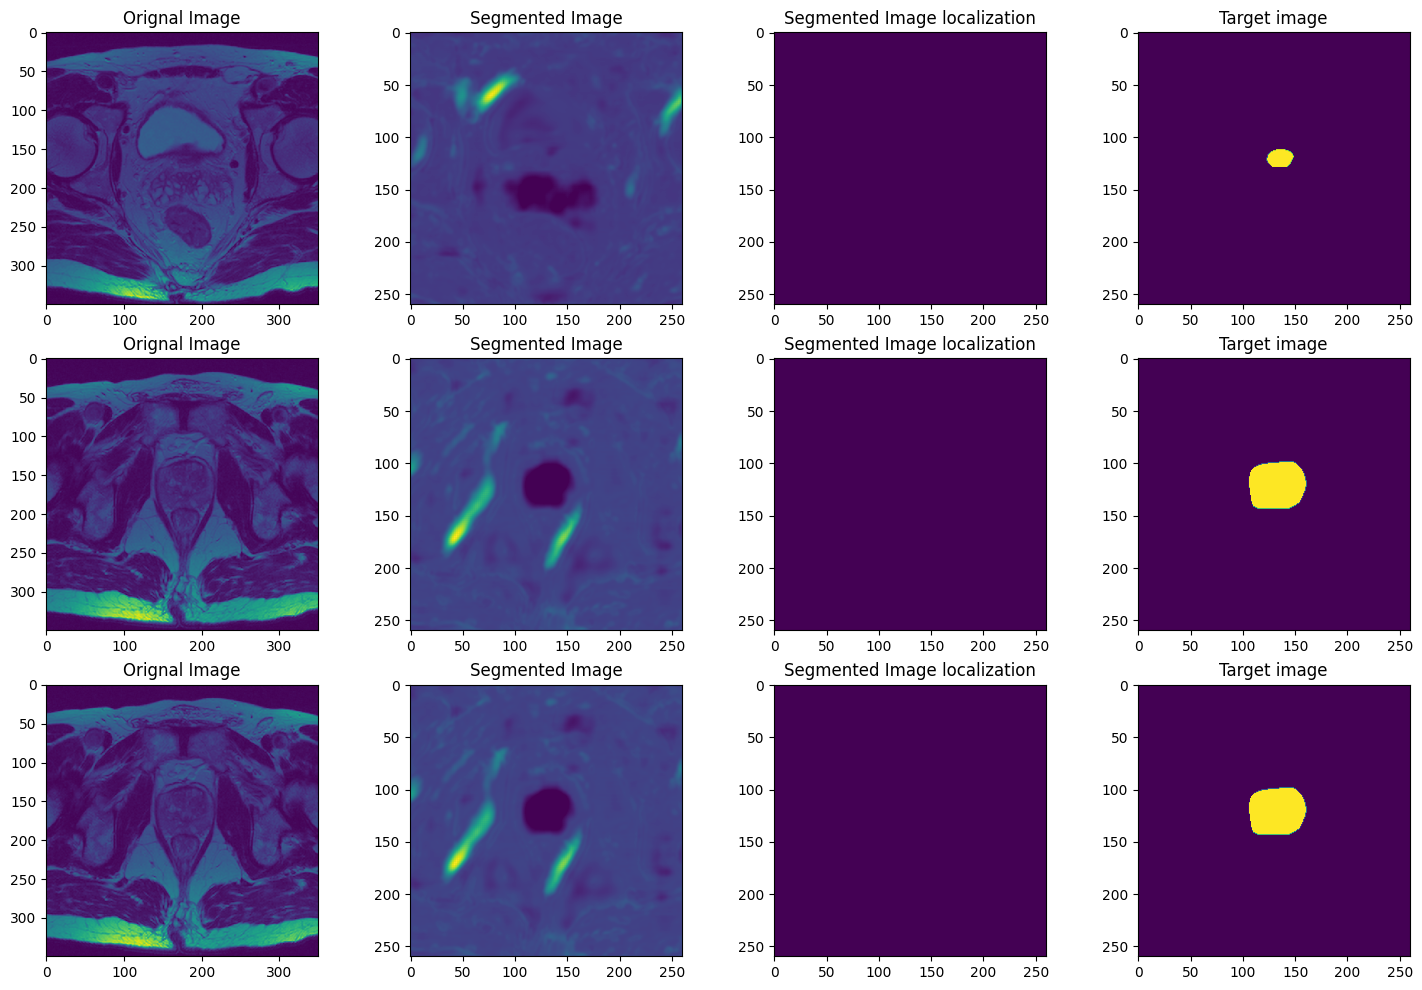

In [75]:
print((x_val.shape, y_val.shape))
plot_examples(x_val[100:110,:,:,:], y_val[100:110,:,:,:])

# comapre

In [28]:
def my_plot(images):
    plt.figure(figsize=(25,20))
#     plt.gray()
    plt.gca()
    plt.subplots_adjust(0,0,1,1,0.01,0.01)
    print(images.shape[0])
    for i in range(images.shape[0]):
        plt.subplot(9,6,i+1), plt.imshow(images[i]), plt.axis('off')
        # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
    plt.show()


train set

(10, 350, 350)
10


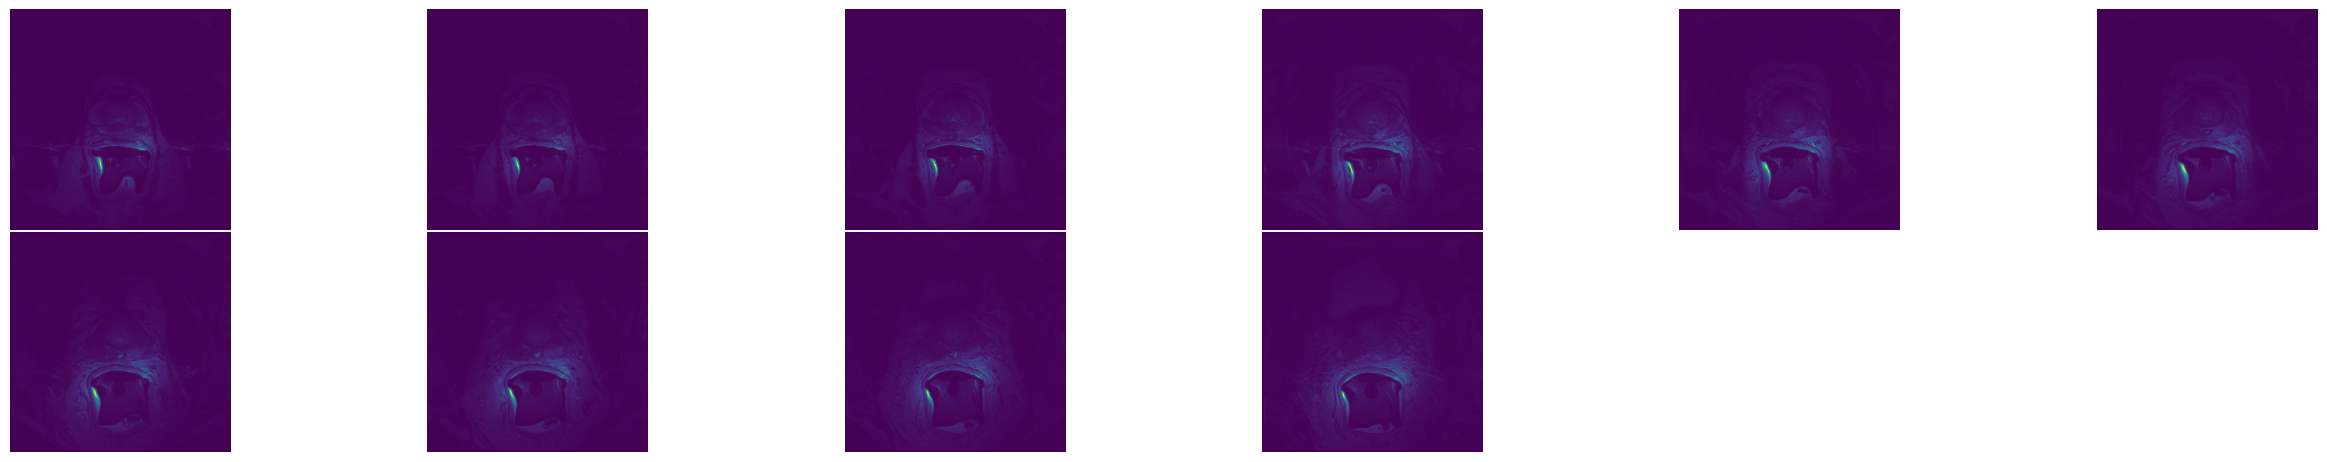

In [70]:
images = np.squeeze(x_train[100:110,:,:,:], axis = 1)

print(images.shape)

my_plot(images)

(10, 260, 260)
10


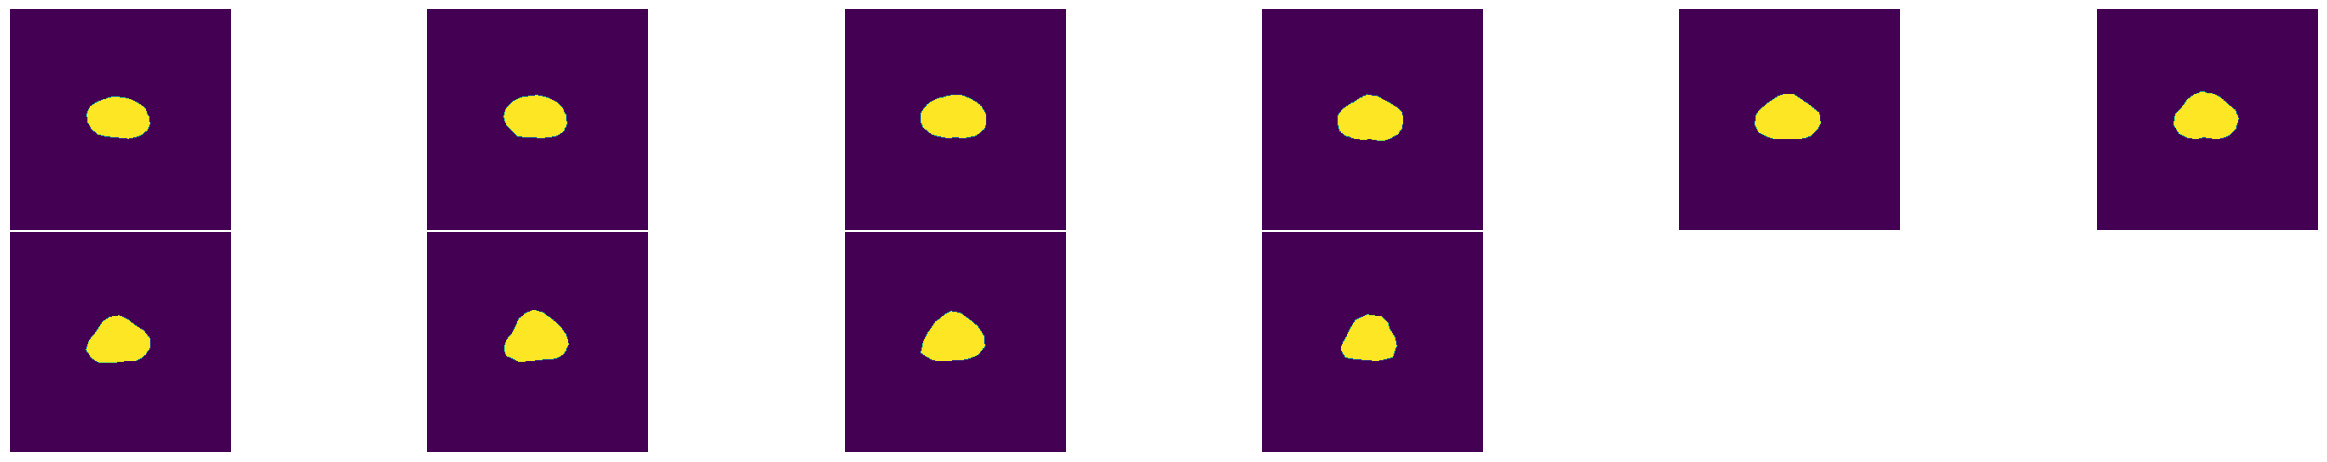

In [71]:
maskes = np.squeeze(y_train[100:110,:,:,:], axis = 1)

print(maskes.shape)

my_plot(maskes)

In [72]:
free_space()
with torch.no_grad():
    inputs, targets = x_train[100:110,:,:,:], y_train[100:110,:,:,:]
    inputs = torch.Tensor(inputs).cuda()
    targets = torch.Tensor(targets).long()
    targets = targets.cuda()


    # compute the model output
    yhat = model(inputs)

(10, 2, 260, 260) <class 'numpy.ndarray'>
(10, 260, 260) <class 'numpy.ndarray'>
10


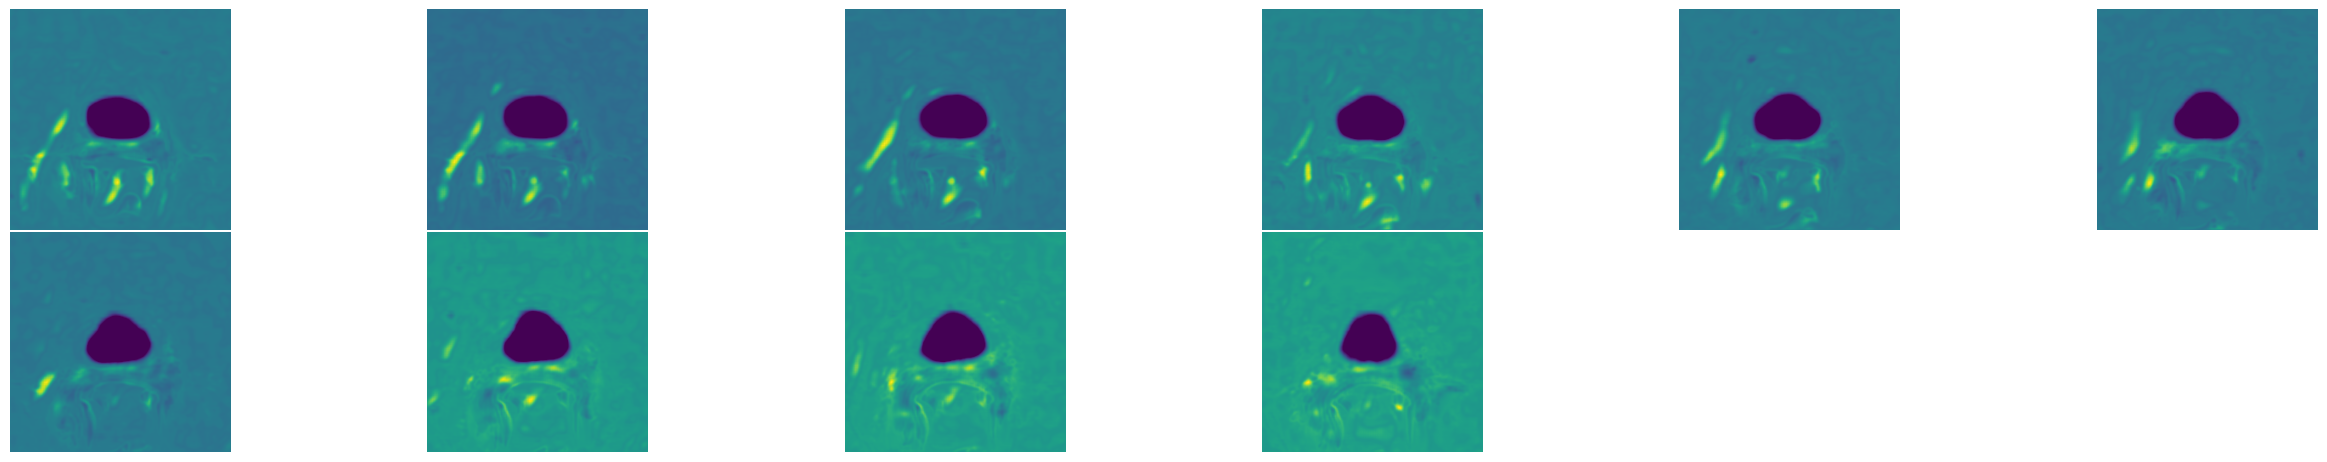

In [73]:
# maskes = np.squeeze(yhat[:,0,:,:].numpy(), axis = 1)
temp = yhat.detach().cpu().numpy()
print(temp.shape, type(temp))
# maskes = temp.argmax(1)
maskes = temp[:,0,:,:]
print(maskes.shape, type(maskes))
my_plot(maskes)

test set

(10, 350, 350)
10


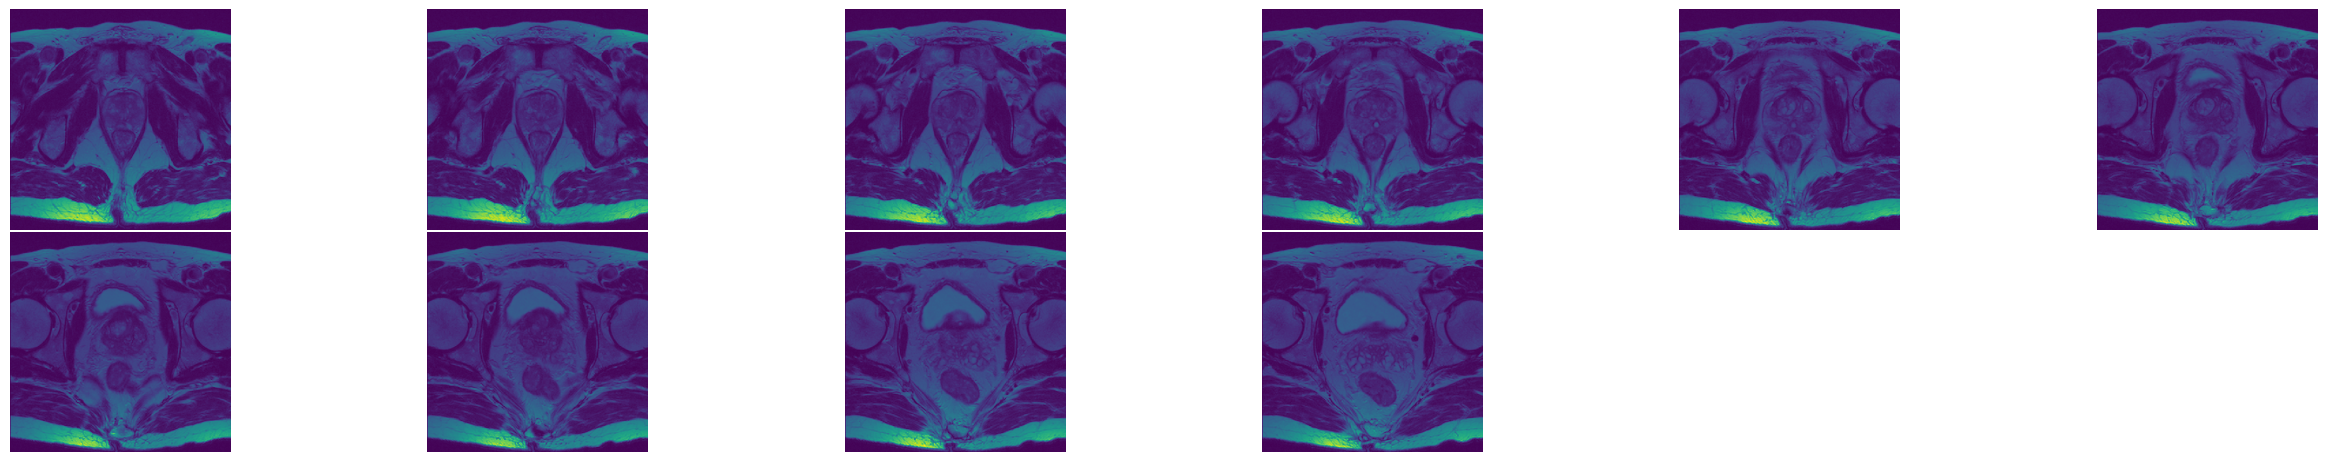

In [65]:
images = np.squeeze(x_val[100:110,:,:,:], axis = 1)

print(images.shape)

my_plot(images)

(10, 260, 260)
10


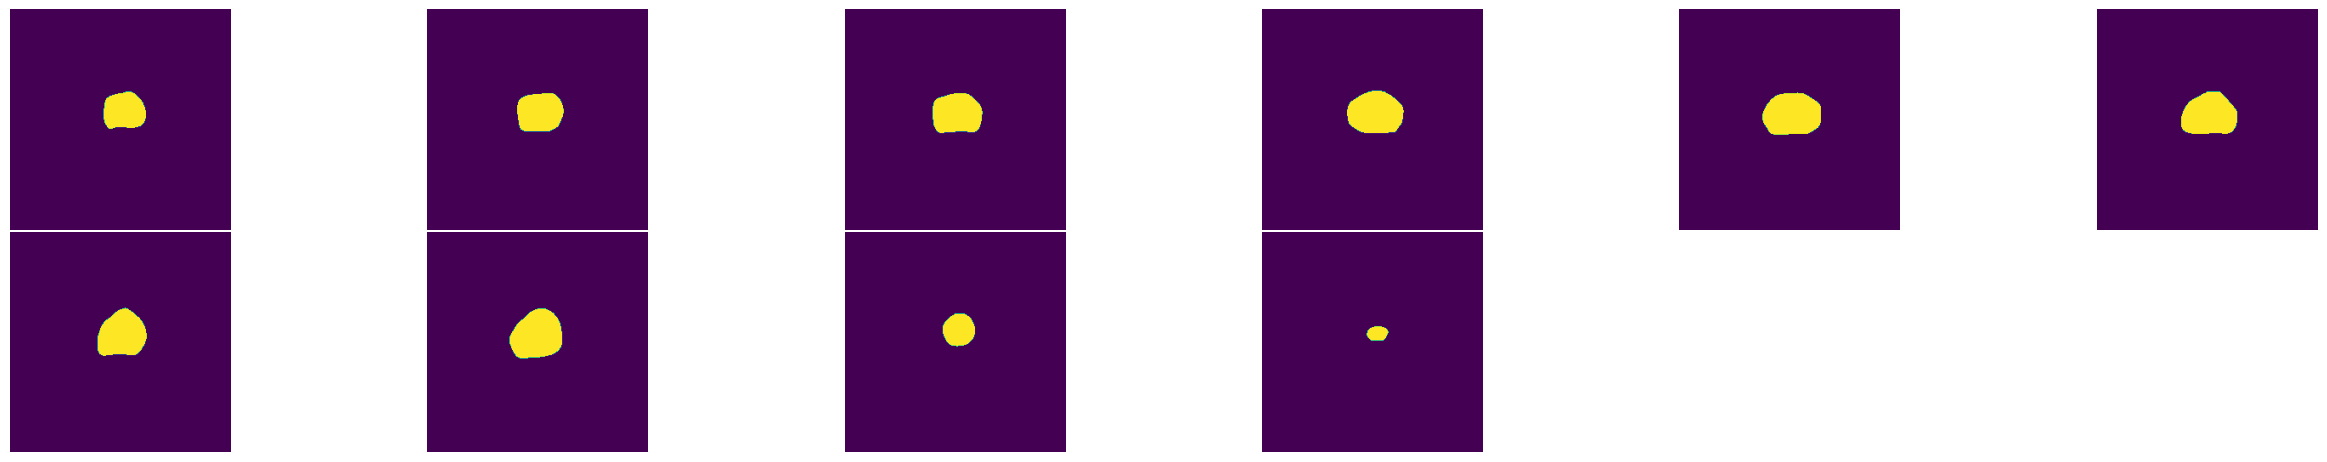

In [55]:
maskes = np.squeeze(y_val[100:110,:,:,:], axis = 1)

print(maskes.shape)

my_plot(maskes)

In [30]:
free_space()

In [66]:
with torch.no_grad():
    inputs, targets = x_val[100:110,:,:,:], y_val[100:110,:,:,:]
    inputs = torch.Tensor(inputs).cuda()
    targets = torch.Tensor(targets).long()
    targets = targets.cuda()


    # compute the model output
    yhat = model(inputs)

(10, 2, 260, 260) <class 'numpy.ndarray'>
(10, 260, 260) <class 'numpy.ndarray'>
10


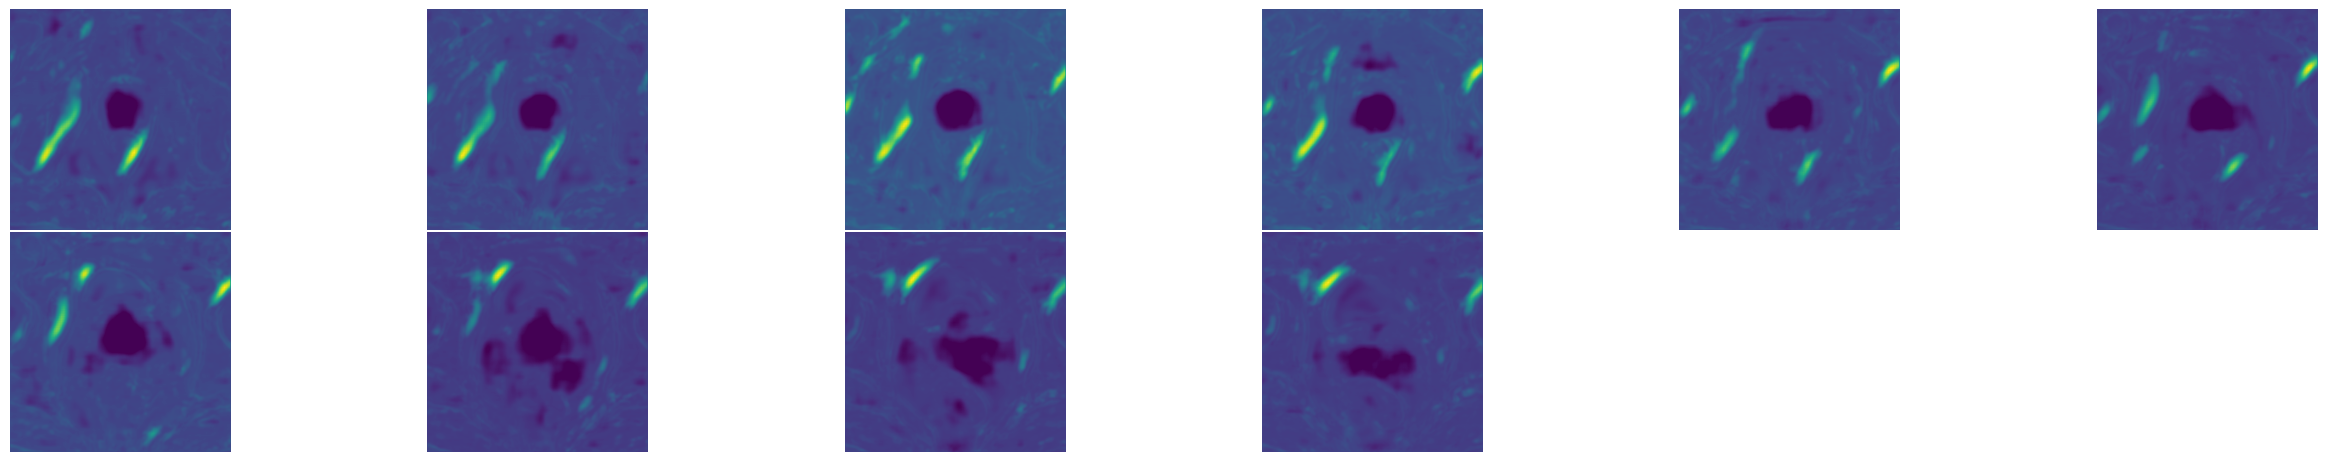

In [69]:
# maskes = np.squeeze(yhat[:,0,:,:].numpy(), axis = 1)
temp = yhat.detach().cpu().numpy()
print(temp.shape, type(temp))
# maskes = temp.argmax(1)
maskes = temp[:,0,:,:]
print(maskes.shape, type(maskes))
my_plot(maskes)

In [37]:
torch.save(model.state_dict(), 'model_saved/100e/pt/model.pt')

In [40]:
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load('model_saved/100e/pt/model.pt))
# model.eval()